In [ ]:
import math
from visualisation import visualise_features, visualise_dataset
from utilities import load_dataframe, performance, cross_validation_feature_params

In [ ]:
# Restart the kernel if needed
# import os
# os._exit(00)

## Exploratory Data Analysis
### Visualise our data

In [ ]:
# Get our dataframe
df = load_dataframe()
visualise_dataset(df)

This doesn't tell us a huge amount. Let's split the volume directions up into separate dataframes and have a closer look.

In [ ]:
# Create two separate data frames, one for each junction
df_north = df.drop(columns=["southBound"])
df_south = df.drop(columns=["northBound"])

For each dataframe, let's look at a seasonality and trend plot. This could illuminate some more details to us

In [ ]:
# Base features performance, where we use K Nearest Neighbors.
# Here is our baseline, now we add features.
performance(df_north, "northBound")
visualise_features(["dayOfWeek", "month", "time"], df_north, f"Base Features - Northbound", "northBound")

performance(df_south, "southBound")
visualise_features(["dayOfWeek", "month", "time"], df_south, f"Base Features - Southbound", "southBound")

### We see:
1. A weekly seasonality
2. A yearly seasonality
3. No overall trend throughout the year

### Extra Features

In [ ]:
df_north["quarter"] = df.index.quarter
df_north["weekOfYear"] = df.index.weekofyear
df_north["dayOfYear"] = df.index.dayofyear

df_south["quarter"] = df.index.quarter
df_south["weekOfYear"] = df.index.weekofyear
df_south["dayOfYear"] = df.index.dayofyear

In [ ]:
performance(df_north, "northBound")
# visualise_features(["quarter", "weekOfYear", "dayOfYear"], df_north, "Additional Features", "northBound")


performance(df_south, "southBound")
# visualise_features(["quarter", "weekOfYear", "dayOfYear"], df_south, "Additional Features", "southBound")

Let's try some more date-related features

In [ ]:
# Get our dataframes back to original features by running cell towards top
df_north = df.drop(columns=["southBound"])
df_south = df.drop(columns=["northBound"])

import pandas as pd
ireland_holidays = {(1,1), (17,3), (5,4), (3,5), (7,6), (2,8), (25,10), (25,12), (26,12)}
# Get our dataframes back to original features
df_north = df.drop(columns=["southBound"])
df_south = df.drop(columns=["northBound"])

# Define a function to use in our mapping
def f(x):
    day = x.day
    month = x.month
    if((day,month) in ireland_holidays):
        return 1
    return 0

df_north["weekday"] = df.index.weekday
series = pd.Series(df_north.index).apply(f)
df_north["holiday"] = series.to_list()
df_north = df_north.fillna(0)

df_south["weekday"] = df.index.weekday
series = pd.Series(df_south.index).apply(f)
df_south["holiday"] = series.to_list()
df_south = df_south.fillna(0)


# Check performance
performance(df_north, "northBound")
performance(df_south, "southBound")

### Review:
Looks like our base features do best.
Newer features perform quite poorly, though this could be because we have such a small dataset right now.#
However, the dayOfYear plot demonstrates some pretty significant seasonality.

## Feature Engineering
### Create lagging features
#### Need to encode components of time series data such as seasonality, trend and cycles.

In [ ]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

rcParams["figure.figsize"] = 20, 5
fig = plot_acf(df_north["northBound"], lags=168)

plt.title("Autocorrelation of Traffic Volume for Northbound traffic (Through a week)")
plt.ylabel("Correlation")
plt.xlabel("Lag at k")
fig.show()

rcParams["figure.figsize"] = 20, 5
fig = plot_acf(df_north["northBound"], lags=24)

plt.title("Autocorrelation of Traffic Volume for Northbound traffic (Through a day)")
plt.ylabel("Correlation")
plt.xlabel("Lag at k")
fig.show()

In [ ]:
temp = df_north.copy()
cross_validation_feature_params(test_params=[1,3,5,7,24], df=temp, feature_type="lag", target_var="northBound")

# Hour
temp["volume_lag_1"] = temp["northBound"].shift(1, fill_value=0)
performance(temp, "northBound")
# Difference feature
temp["volume_lag_1_diff"] = temp["northBound"] - temp["volume_lag_1"]
performance(temp, "northBound")
# # Day
# temp["volume_lag_24"] = temp["northBound"].shift(24, fill_value=0)
# performance(temp, "northBound")
# # Week
# temp["volume_lag_week"] = temp["northBound"].shift(168, fill_value=0)
# performance(temp, "northBound")


Set a lag of 1, and a difference

In [ ]:
df_north = df.drop(columns=["southBound"])
df_south = df.drop(columns=["northBound"])

df_north = df.drop(columns=["southBound"])
df_north["volume_lag_1"] = df_north["northBound"].shift(1, fill_value=0)
df_north["volume_lag_1_diff"] = df_north["volume_lag_1"] - df_north["northBound"].shift(2, fill_value=0)
performance(df_north, "northBound")

df_south = df.drop(columns=["northBound"])
df_south["volume_lag_1"] = df_south["southBound"].shift(1, fill_value=0)
df_south["volume_lag_1_diff"] = df_north["volume_lag_1"] - df_south["southBound"].shift(2, fill_value=0)
performance(df_south, "southBound")

Some improvement when using a lag of 1. Anything higher results in pretty poor results, Let's try a Rolling Window Feature

### Rolling Window Features
For this, we'll try the mean, min, max, and sum in each window.

In [ ]:
temp = df_north.copy()
cross_validation_feature_params(test_params=[2,3,5,7,9,11,13,24], df=temp, feature_type="rolling_window_max", target_var="northBound")
temp['window_max'] = temp['northBound'].rolling(window = 2).max()
temp['window_max'] = temp['window_max'].fillna(0)
performance(temp, "northBound")




Lower error again with the rolling window. Try mean rolling window

In [ ]:
temp_a = df_north.copy()
cross_validation_feature_params(test_params=[2,3,5,7,9,11,13], df=temp, feature_type="rolling_window_mean", target_var="northBound")
temp['window_mean'] = temp['northBound'].rolling(window = 2).mean()
temp['window_mean'] = temp['window_mean'].fillna(0)
performance(temp, "northBound")

Much better again! See if min does any better

In [ ]:
temp = df_north.copy()
cross_validation_feature_params(test_params=[2,3,5,7,9,11,13], df=temp, feature_type="rolling_window_min", target_var="northBound")
temp['window_min'] = temp['northBound'].rolling(window = 2).min()
temp['window_min'] = temp['window_min'].fillna(0)
performance(temp, "northBound")

In [ ]:
temp.head(13)

Not quite as good.

Let's add the mean rolling window as a feature. These will be added once we've figured out how to use em for forecasting. They do a pretty nice job though.

In [ ]:
# # Northbound
# df_north['window_mean'] = df_north['northBound'].rolling(window = 2).mean()
# df_north['window_mean'] = df_north['window_mean'].fillna(0)
# performance(df_north, "northBound")
# # Southbound
# df_south['window_mean'] = df_south['southBound'].rolling(window = 2).mean()
# df_south['window_mean'] = df_south['window_mean'].fillna(0)
# performance(df_south, "southBound")

We see better performance as we dont have the cross validated features also in the dataframe. 
This performance is particularly good for such a basic model!

## Model Training

We're going to try a few different models provided by sklearn. We could look beyond into things like Keras, ARIMA and XGBOOST, but I don't think it's necessary for this assignment.


Hold out a validation set. This will be used later once we've narrowed down the params for each model.

In [ ]:
# We're going to hold out 12 hours of data points to predict on!~
def train_test_split(X,y,test_size):
	return (X[:-test_size, :], X[-test_size:, :], y[:-test_size], y[-test_size:])

In [ ]:
# Forecast size
n_forecast = 1000

In [ ]:
# Target Variable
y_north = df_north["northBound"].to_numpy()
y_south = df_south["southBound"].to_numpy()

# Feature Vectors
X_north = df_north.drop(columns=["northBound"]).to_numpy()
X_south = df_south.drop(columns=["southBound"]).to_numpy()

# Hold out a validation set
(X_north, X_north_val, y_north, y_north_val) = train_test_split(X_north, y_north, test_size=n_forecast)
(X_south, X_south_val, y_south, y_south_val) = train_test_split(X_south, y_south, test_size=n_forecast)

So, let's look into Lasso and Ridge Regression first.

In [ ]:
from models import evaluate_lasso_hyperparams, evaluate_ridge_hyperparams
evaluate_lasso_hyperparams(X_north,y_north, [3,50,100,200,300])
evaluate_ridge_hyperparams(X_north,y_north, [0.000001,0.0001,0.1,10])


Pretty awful performance lol. Not really surprising though. What is surprising is how well kNN does...

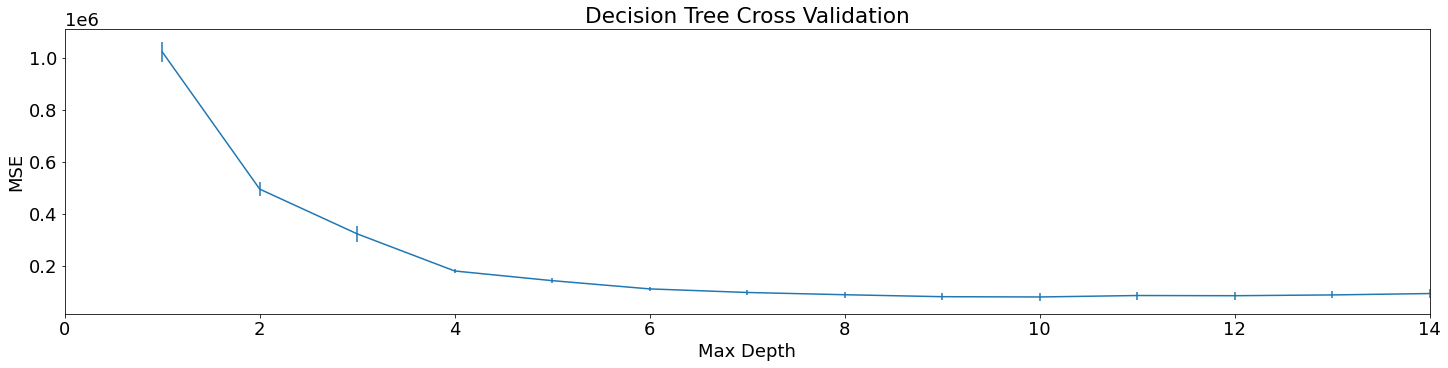

In [51]:
from models import evaluate_decision_tree_hyperparams
decision_tree_model=evaluate_decision_tree_hyperparams(X_north,y_north, [i for i in range(1,15)])

A Max Depth of 8 looks good here

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from utilities import n_one_step_ahead_prediction
from sklearn.metrics import mean_squared_error
from visualisation import visualise_forecast_vs_true
from sklearn.model_selection import cross_validate, TimeSeriesSplit
import numpy as np



decision_tree_model=DecisionTreeRegressor(max_depth=8).fit(X_north,y_north)
cv =TimeSeriesSplit(5)
scores = cross_validate(
        decision_tree_model,
        X_north,
        y_north,
        cv=cv,
        scoring="neg_mean_squared_error",
        return_estimator=True,
    )

base_mse = np.sqrt(-np.mean(scores["test_score"]))
print(f"MSE is: {format(base_mse)}")


Lets try build on our decision tree using AdaBoost
Tuning parameters takes a while so I'll leave it commented out

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV

from models import evaluate_ada_boost_hyperparams
from utilities import get_decision_tree_models

params_grid={
    "base_estimator": [model for model in get_decision_tree_models(max_depth_array=range(1,20))],
    "n_estimators":[i for i in range(5,150,5)],
    "learning_rate":[0.01,0.1,1,1.5,2,5,10],
    "loss":['linear', 'square', 'exponential']
}

#evaluate_ada_boost_hyperparams(X_north,y_north,params_grid) 

In [ ]:
ada_boost_model = AdaBoostRegressor(
    base_estimator=DecisionTreeRegressor(max_depth=15),
    n_estimators=90,
    learning_rate=0.01,
    loss='exponential').fit(X_north,y_north)

scores = cross_validate(
        ada_boost_model,
        X_north,
        y_north,
        cv=cv,
        scoring="neg_mean_squared_error",
        return_estimator=True,
    )

base_mse = np.sqrt(-np.mean(scores["test_score"]))
print(f"Ada Boost Performance MSE is: {format(base_mse)}")


Bit better than the original decision tree..

Random Grid search to find the best combination of params for a random forest.
With those best params, we then test the performance. Takes a while...

In [ ]:
from models import evaluate_random_forest_hyperparams
test_params = {
"n_estimators": [20, 50, 60, 100],
'max_features': ['auto', 'sqrt', 'log2'],
'max_depth' : [i for i in range(5,20)]
}
evaluate_random_forest_hyperparams(X_north, y_north, test_params)

In [ ]:
# get a figure for the performance
from sklearn.ensemble import RandomForestRegressor
cv = TimeSeriesSplit(n_splits=5)
rf_model = RandomForestRegressor(n_estimators=60, max_features="auto",max_depth=14)
scores = cross_validate(
        rf_model,
        X_north,
        y_north,
        cv=cv,
        scoring="neg_mean_squared_error",
        return_estimator=True,
    )

base_mse = np.sqrt(-np.mean(scores["test_score"]))
print(f"MSE is: {format(base_mse)}")

Let's get the best hyper params for an ANN. We'll plot the error bars for it since the slides do it. Takes about six minutes to run... Comment it out then run it once everything else is done.

In [ ]:
from models import evaluate_MLP_hidden_nodes, evaluate_MLP_penalty_weight
#evaluate_MLP_hidden_nodes(X_north,y_north, [5,10,15,30,50,100])
#evaluate_MLP_penalty_weight(X_north,y_north, [0.1,1,10,100,1000])

## Validation

Decision Tree

In [ ]:

y_forecast_north = n_one_step_ahead_prediction(decision_tree_model, X_north_val, n=n_forecast)
print("MSE: "+str(mean_squared_error(y_north_val, y_forecast_north)))
x_axis = df.iloc[-n_forecast:].index.to_numpy()
visualise_forecast_vs_true(x_axis,y_north_val,y_forecast_north,"Decision Tree")

Ada Boost

In [ ]:
y_forecast_north = n_one_step_ahead_prediction(ada_boost_model, X_north_val, n=n_forecast)
print("MSE: "+str(mean_squared_error(y_north_val, y_forecast_north)))
x_axis = df.iloc[-n_forecast:].index.to_numpy()
visualise_forecast_vs_true(x_axis,y_north_val,y_forecast_north,"Ada Boost")

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=60, max_features="auto",max_depth=14).fit(X_north, y_north)
y_forecast_north = n_one_step_ahead_prediction(rf_model, X_north_val, n=n_forecast)
print(mean_squared_error(y_north_val, y_forecast_north))


In [ ]:
# Visualise this
visualise_forecast_vs_true(x_axis, y_north_val, y_forecast_north, model_name="Random Forest")

Neural Network

In [ ]:
from sklearn.neural_network import MLPRegressor
mlp_model = MLPRegressor(hidden_layer_sizes=100, alpha=1000,max_iter=500).fit(X_north, y_north)
y_forecast_north = n_one_step_ahead_prediction(mlp_model, X_north_val, n=n_forecast)
print(mean_squared_error(y_north_val, y_forecast_north))

In [ ]:
visualise_forecast_vs_true(x_axis, y_north_val, y_forecast_north, model_name="MLP")

Ooff